In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder =  "./MovieReviews/"

### Load Data and preprocess

In [4]:
class_type = 4
def continous_2_cat(data):
    if data == -1:
        return -1
    if class_type ==3:
        if data <= 0.4:
            return 0
        elif data < 0.7:
            return 1
        else:
            return 2
    elif class_type == 4:
        if data <= 0.3:
            return 0
        elif data <= 0.5:
            return 1
        elif data <= 0.7:
            return 2
        else:
            return 3

In [7]:
##stratified range..
limits = [0]
pos_values = np.unique(targets_train)

N = targets_train.shape[0]
splits = 7 #5 ,7,8
acum_split = []
data_by_split = N/(splits) #minimum data on split
print("Minimum data on split: ",data_by_split)

for i in range(splits-1):
    if i != len(limits)-1:
        break
    upper_values = pos_values[pos_values>=limits[i]]
    for value in upper_values: #find the upper limit
        range_v = (limits[i] <= targets_train ) & (targets_train < value)
        if np.sum(range_v) >= data_by_split:
            limits.append(value)
            acum_split.append(np.sum(range_v))
            break
range_v = (limits[-1] <= targets_train ) & (targets_train <=1)
limits.append(np.max(pos_values)+0.1)
acum_split.append(np.sum(range_v))
limits = np.asarray(limits)

print("Splits obtained: ",len(acum_split))
print("Splits obtained ammount: ",acum_split)

def continous_2_cat(data):
    if data == -1:
        return -1
    return np.where(limits <= data )[0][-1]
limits

Minimum data on split:  214.0
Splits obtained:  6
Splits obtained ammount:  [387, 277, 252, 287, 215, 80]


array([0.  , 0.41, 0.51, 0.61, 0.71, 0.86, 1.1 ])

In [5]:
from keras import preprocessing
def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

texts_train = read_texts(folder+"texts_train.txt")
targets_train = np.loadtxt(folder+"ratings_train.txt")
Z_train = np.asarray(list(map(continous_2_cat,targets_train )))

texts_test = read_texts(folder+"texts_test.txt")
targets_test = np.loadtxt(folder+"ratings_test.txt")
Z_test = np.asarray(list(map(continous_2_cat,targets_test )))

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 1498
Num. test texts:  3508


In [6]:
MAX_NB_WORDS = 40000 #probar cambiara 10mil o 2mil
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

(-100, 40000)

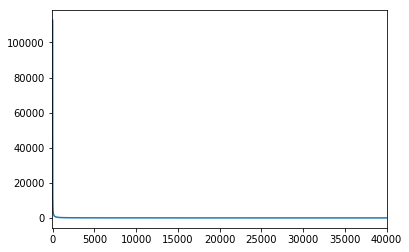

In [8]:
aux = np.asarray(list(tokenizer.word_counts.values()))
plt.plot(np.sort(aux)[::-1])
plt.xlim(-100,MAX_NB_WORDS)

In [7]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)
max_L = 1000 #Rodrigues
print("Used max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  1384
Used max:  1000
Shape of train tensor: (1498, 1000)


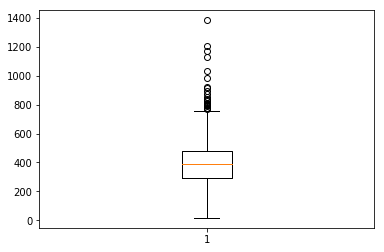

In [8]:
plt.boxplot(lens)
plt.show()

In [8]:
GLOVE_DIR = "../GLOVE/" #"../AUX_DATA/glove.6B/"
embeddings_index = {}
with open(GLOVE_DIR + 'glove.6B.100d.txt') as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
EMBEDDING_DIM = 100
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i <= MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
del embeddings_index, sorted_x, tokenizer
gc.collect()

Preparing embedding matrix.


7

### Load annotations / Generate

In [9]:
from code.representation import *
from code.utils import *

print("Loading AMT data...")
answers = pd.read_csv(folder+"answers.txt", header=None, delimiter=" ").as_matrix()
answers = answers[:,:-1]
answers[answers == 1.1] = 1.
answers[answers == -0.1] = 0.

y_obs = np.empty_like(answers)
for i in range(answers.shape[0]):
    y_obs[i] = list(map(continous_2_cat, answers[i]))
y_obs = y_obs.astype('int16')
N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Shape (data,annotators):  (1498, 135)
Classes:  4


In [17]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [ ]:
##  volver a pensar mejor lo de abajo..

In [10]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.9386503 , 0.06134969, 0.        , 0.        ],
        [0.18577981, 0.76376146, 0.05045871, 0.        ],
        [0.00203252, 0.18495935, 0.76829267, 0.04471545],
        [0.        , 0.        , 0.3022388 , 0.6977612 ]],

       [[0.        , 0.01754386, 0.0877193 , 0.8947368 ],
        [0.        , 0.03053435, 0.129771  , 0.8396947 ],
        [0.        , 0.04225352, 0.09154929, 0.86619717],
        [0.        , 0.06410257, 0.12820514, 0.8076923 ]],

       [[1.        , 0.        , 0.        , 0.        ],
        [0.4       , 0.53333336, 0.06666667, 0.        ],
        [0.09090909, 0.36363637, 0.36363637, 0.18181819],
        [0.        , 0.        , 0.42857143, 0.5714286 ]],

       ...,

       [[0.        , 1.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ],
        [0.        , 0.2       , 0.6       , 0.2       ],
        [0.25      , 0.25      , 0.25      , 0.25      ]],

       [[1.        , 0.        , 0.        , 0.    

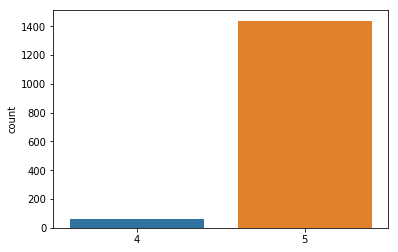

Minimum annotations in a example:  4
Maximum annotations in a example:  5
T data (expected value):  4.959946595460615
Graphics of T weights


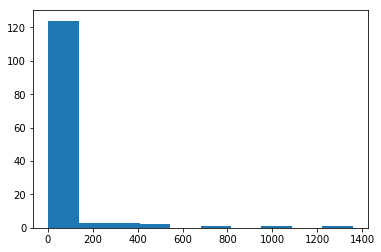

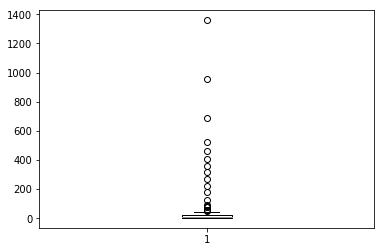

Minimum annotations by an annotator:  2
Maximum annotations by an annotator:  1359
Mean annotations by an annotator:  55.03703703703704


In [12]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, default_CNN_text, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [12]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)

Trained IDeal Model, Epochs to converge = 25


In [12]:
Z_test_onehot = keras.utils.to_categorical(Z_test)
Z_train_onehot = keras.utils.to_categorical(Z_train)


In [70]:
class KMaxPooling(keras.engine.Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension). TensorFlow backend.
    """
    def __init__(self, k=1, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = keras.engine.InputSpec(ndim=3)
        self.k = k

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.k, input_shape[2])

    def call(self, inputs):
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1]) 
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=self.k, sorted=True, name=None)[0] 
        return tf.transpose(top_k, [0, 2, 1])

import math
import tensorflow as tf
def K_l(L,seq_len,k_top,layer=1): #dinamyc k-max
    return max(k_top, math.ceil( seq_len*(L-layer)/L) )

def add_conv_bloq(model, filters, kernel_s, BN=False, drop=0,padding='same',dil_r=1):
    model.add(Conv1D(filters, kernel_s, strides=1, padding=padding, activation='relu',dilation_rate=dil_r))
    if BN:
        model.add(BatchNormalization())
    #if dil_r == 1:
    #    model.add(Conv1D(filters, kernel_s, strides=1, padding=padding, activation='relu',dilation_rate=dil_r))
    #    if BN:
    #        model.add(BatchNormalization())
    if drop != 0:
        model.add(Dropout(drop))

def build_kpool_model(input_dim, out_shape, units, L=1,kernel_s =10, K_top=500,
                        BN = False, drop=0, padding='valid', embed_M =[]): #parametros estructurales
    model = Sequential()
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
        
    for l in range(L):
        add_conv_bloq(model, units, kernel_s, BN=BN,drop=drop,padding=padding)

        model.add(KMaxPooling(k = K_l(L, input_dim, K_top, layer=l+1)))
        #units = int(units*2)
    
    model.add(GlobalAveragePooling1D())  #u otra cosa
    
    #model.add(Dense(64,activation='relu'))
    #if drop>0:
    #    model.add(Dropout(drop))
    model.add(Dense(out_shape, activation='softmax'))
    return model

In [55]:
from keras.models import Sequential,Model
from keras.layers import *
def default_CNN_text(input_dim,output_dim,embed_M=[]):
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim) #true
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
            
    model.add(Conv1D(128, 5, activation='relu')) #kernel 5?
    model.add(BatchNormalization())
    #model.add(Conv1D(128, 3, activation='relu')) #kernel 5?
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Conv1D(128, 3, activation='relu')) #kernel 5?
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.5))
    
    model.add(GlobalAveragePooling1D())
    
    #model.add(Flatten())
    #model.add(Dense(128, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_dim, activation='softmax')) 
    return model

In [43]:
model_UB = default_CNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
model_UB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 100)         4000100   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
batch_normalization_23 (Batc (None, 996, 128)          512       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 199, 128)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
batch_normalization_24 (Batc (None, 195, 128)          512       
__________

In [98]:
model_UB = build_kpool_model(max_L,Kl, 128, L=3,kernel_s=5, K_top=30, BN=False,drop=0.2, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
model_UB.summary()

#probar 2 capas
#probar menos K .. 30

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 1000, 100)         4000100   
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
dropout_39 (Dropout)         (None, 996, 128)          0         
_________________________________________________________________
k_max_pooling_41 (KMaxPoolin (None, 667, 128)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 663, 128)          82048     
_________________________________________________________________
dropout_40 (Dropout)         (None, 663, 128)          0         
_________________________________________________________________
k_max_pooling_42 (KMaxPoolin (None, 334, 128)          0         
__________

In [99]:
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2#,callbacks=[ourCallback]
                  ,validation_data=(X_test,Z_test_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Train on 1498 samples, validate on 3508 samples
Epoch 1/50
 - 20s - loss: 1.6926 - acc: 0.3251 - val_loss: 1.3081 - val_acc: 0.3931
Epoch 2/50
 - 17s - loss: 1.3119 - acc: 0.3732 - val_loss: 1.3264 - val_acc: 0.3942
Epoch 3/50
 - 17s - loss: 1.3071 - acc: 0.3645 - val_loss: 1.3172 - val_acc: 0.3960
Epoch 4/50
 - 17s - loss: 1.2942 - acc: 0.3985 - val_loss: 1.3014 - val_acc: 0.3977
Epoch 5/50
 - 17s - loss: 1.2765 - acc: 0.3959 - val_loss: 1.2933 - val_acc: 0.4170
Epoch 6/50
 - 17s - loss: 1.2553 - acc: 0.4179 - val_loss: 1.2542 - val_acc: 0.4287
Epoch 7/50
 - 17s - loss: 1.2040 - acc: 0.4426 - val_loss: 1.2807 - val_acc: 0.3027
Epoch 8/50
 - 17s - loss: 1.2120 - acc: 0.4366 - val_loss: 1.2387 - val_acc: 0.3885
Epoch 9/50
 - 17s - loss: 1.1841 - acc: 0.4586 - val_loss: 1.2097 - val_acc: 0.4322
Epoch 10/50
 - 17s - loss: 1.1690 - acc: 0.4713 - val_loss: 1.1881 - val_acc: 0.4521
Epoch 11/50
 - 17s - loss: 1.1288 - acc: 0.4806 - val_loss: 1.1762 - val_acc: 0.4538
Epoch 12/50
 - 17s - loss:

KeyboardInterrupt: 

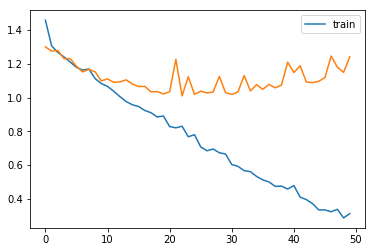

In [93]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [48]:
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)

### Infer Labels (without predictive model)

In [15]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.045258 sec
Representation for DS in 0.021206 sec
Estimation MV in 0.000260 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -7095.1264157972055
2 	 -6559.673166239629 	0.1106	0.283549	0.075468
3 	 -6478.046837314956 	0.0185	0.185442	0.012444
4 	 -6459.050526888232 	0.0111	0.145406	0.002932
5 	 -6452.410832659263 	0.0084	0.097956	0.001028
6 	 -6449.318114545813 	0.0066	0.069387	0.000479
7 	 -6447.423287940699 	0.0051	10416.717773	0.000294
8 	 -6446.112994342271 	0.0039	6944.488770	0.000203
9 	 -6445.236603640004 	0.0030	3472.259033	0.000136
10 	 -6444.683698826544 	0.0025	3472.253906	0.000086
11 	 -6444.3058935970375 	0.0022	0.024133	0.000059
Class marginals
[0.25 0.3  0.28 0.17]
Estimation for DS in 2.921756 sec


In [55]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6381842456608812
ACC D&S on train: 0.6862483311081442


In [16]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(X_train)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Trained model over soft-MV, Epochs to converge = 5


In [18]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(X_train)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 34


In [20]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(X_train)
Z_test_pred = model_ds.predict_classes(X_test)

Trained model over D&S, Epochs to converge = 15


### Raykar Model (joint predict model)

In [22]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1498, 135, 4)


In [23]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(15,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (135, 4, 4)
Q estimate shape:  (1498, 4)
Iter 1/50 
M step: done,  E step: done //  (in 6.16 sec)	logL: -7460.017	
Iter 2/50 
M step: done,  E step: done //  (in 4.22 sec)	logL: -7004.778	Tol1: 0.06102	Tol2: 0.11375	
Iter 3/50 
M step: done,  E step: done //  (in 4.22 sec)	logL: -6711.114	Tol1: 0.04192	Tol2: 0.05034	
Iter 4/50 
M step: done,  E step: done //  (in 4.25 sec)	logL: -6683.056	Tol1: 0.00418	Tol2: 0.02432	
Finished training
Initializing new EM...
Betas shape:  (135, 4, 4)
Q estimate shape:  (1498, 4)
Iter 1/50 
M step: done,  E step: done //  (in 5.53 sec)	logL: -7470.332	
Iter 2/50 
M step: done,  E step: done //  (in 4.21 sec)	logL: -7051.452	Tol1: 0.05607	Tol2: 0.10983	
Iter 3/50 
M step: done,  E step: done //  (in 4.20 sec)	logL: -7002.281	Tol1: 0.00697	Tol2: 0.04721	
Iter 4/50 
M step: done,  E step: done //  (in 4.21 sec)	logL: -6653.740	Tol1: 0.04978	Tol2: 0.05349	
Iter 5/50 
M step: done,  E step: done //  (in 4.19 sec)	logL: -67

M step: done,  E step: done //  (in 4.17 sec)	logL: -6482.508	Tol1: 0.00959	Tol2: 0.02377	
Finished training
Initializing new EM...
Betas shape:  (135, 4, 4)
Q estimate shape:  (1498, 4)
Iter 1/50 
M step: done,  E step: done //  (in 5.56 sec)	logL: -7583.045	
Iter 2/50 
M step: done,  E step: done //  (in 4.25 sec)	logL: -6940.470	Tol1: 0.08474	Tol2: 0.11478	
Iter 3/50 
M step: done,  E step: done //  (in 4.23 sec)	logL: -6843.868	Tol1: 0.01392	Tol2: 0.04929	
Iter 4/50 
M step: done,  E step: done //  (in 4.20 sec)	logL: -6897.130	Tol1: 0.00778	Tol2: 0.03109	
Iter 5/50 
M step: done,  E step: done //  (in 4.18 sec)	logL: -6501.113	Tol1: 0.05742	Tol2: 0.04061	
Iter 6/50 
M step: done,  E step: done //  (in 4.24 sec)	logL: -6449.038	Tol1: 0.00801	Tol2: 0.01995	
Finished training
Multiples runs over Raykar, Epochs to converge=  5.2


In [24]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

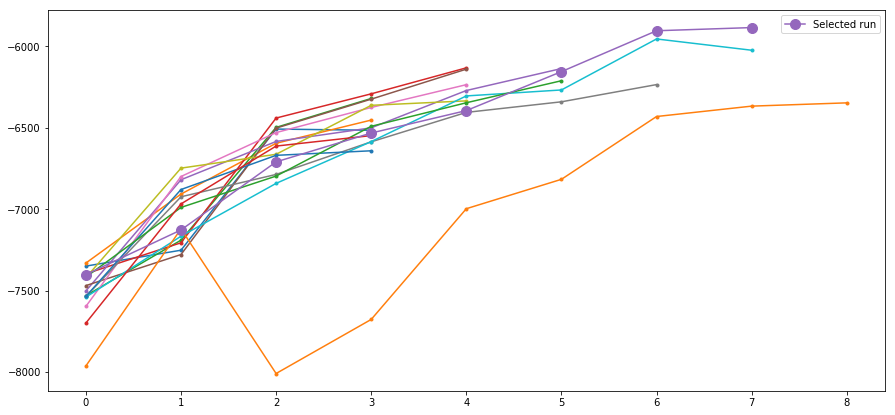

In [65]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [67]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [68]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[4 0 0 1]
 [3 0 2 0]
 [4 0 0 1]
 ...
 [0 0 0 5]
 [0 0 1 4]
 [0 0 2 3]]
shape: (1498, 4)


Normalized entropy (0-1) of repeats annotations: 0.4942555201452063


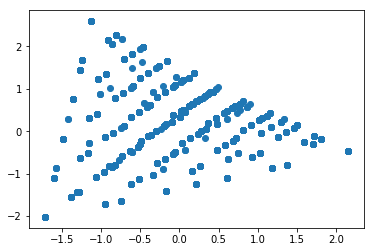

In [29]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005395 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (1498, 4)
Betas:  (5, 4, 4)
Q estimate:  (1498, 4, 5, 4)
Iter 1/0
M step: done,  E step: done //  (in 2.28 sec)	logL: -10121.969	
Finished training!


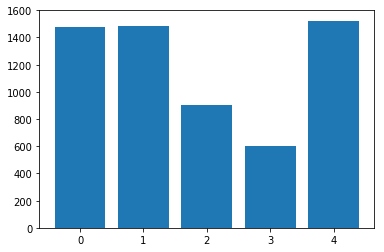

<BarContainer object of 5 artists>

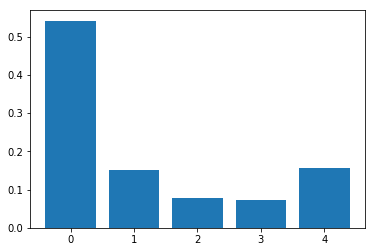

In [32]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default cnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("default cnn text", embed=embedding_matrix)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [ ]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [69]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [70]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default cnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(15,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.004885 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1498, 4)
Betas:  (3, 4, 4)
Q estimate:  (1498, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 4.57 sec)	logL: -10106.645	
Iter 2/50
M step: done,  E step: done //  (in 1.31 sec)	logL: -9357.680	Tol1: 0.07411	Tol2: 0.34269	Tol3: 0.10268	
Iter 3/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -9368.585	Tol1: 0.00117	Tol2: 0.14047	Tol3: 0.00365	
Iter 4/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -9357.489	Tol1: 0.00118	Tol2: 0.23448	Tol3: 0.03620	
Iter 5/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -8868.471	Tol1: 0.05226	Tol2: 0.27093	Tol3: 0.05717	
Iter 6/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -8853.781	Tol1: 0.00166	Tol2: 0.16500	Tol3: 0.04460	
Iter 7/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -8532.016	Tol1: 0.03634	Tol2: 0.19219	Tol3: 0.05027	
Iter 8/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 1.46 sec)	logL: -8314.327	Tol1: 0.01002	Tol2: 0.11020	Tol3: 0.00705	
Iter 38/50
M step: done,  E step: done //  (in 1.39 sec)	logL: -8139.022	Tol1: 0.02108	Tol2: 0.14267	Tol3: 0.00864	
Iter 39/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -8052.617	Tol1: 0.01062	Tol2: 0.10481	Tol3: 0.01413	
Iter 40/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -7852.014	Tol1: 0.02491	Tol2: 0.16779	Tol3: 0.00620	
Iter 41/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -7882.017	Tol1: 0.00382	Tol2: 0.09160	Tol3: 0.00017	
Iter 42/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -8183.928	Tol1: 0.03830	Tol2: 0.07501	Tol3: 0.01002	
Iter 43/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -7688.776	Tol1: 0.06050	Tol2: 0.20606	Tol3: 0.01452	
Iter 44/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -7819.790	Tol1: 0.01704	Tol2: 0.08489	Tol3: 0.01864	
Iter 45/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -7619.768	Tol1: 0.02

M step: done,  E step: done //  (in 5.03 sec)	logL: -9795.836	
Iter 2/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9346.210	Tol1: 0.04590	Tol2: 0.29349	Tol3: 0.09740	
Iter 3/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9155.152	Tol1: 0.02044	Tol2: 0.13363	Tol3: 0.02693	
Iter 4/50
M step: done,  E step: done //  (in 1.34 sec)	logL: -8992.879	Tol1: 0.01772	Tol2: 0.11917	Tol3: 0.00892	
Iter 5/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -9033.524	Tol1: 0.00452	Tol2: 0.15796	Tol3: 0.01941	
Iter 6/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -8461.691	Tol1: 0.06330	Tol2: 0.28106	Tol3: 0.03649	
Iter 7/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -8229.358	Tol1: 0.02746	Tol2: 0.14786	Tol3: 0.00662	
Iter 8/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -8657.516	Tol1: 0.05203	Tol2: 0.16271	Tol3: 0.01199	
Iter 9/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -7924.497	Tol1: 0.08467	Tol2: 0.31688	Tol3: 0.03742	
Iter 10/50
M step

M step: done,  E step: done //  (in 1.41 sec)	logL: -8861.372	Tol1: 0.00945	Tol2: 0.04884	Tol3: 0.00286	
Iter 40/50
M step: done,  E step: done //  (in 1.38 sec)	logL: -8847.942	Tol1: 0.00152	Tol2: 0.04967	Tol3: 0.00339	
Iter 41/50
M step: done,  E step: done //  (in 1.39 sec)	logL: -8967.865	Tol1: 0.01355	Tol2: 0.07407	Tol3: 0.00232	
Iter 42/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -8680.573	Tol1: 0.03204	Tol2: 0.09917	Tol3: 0.00162	
Iter 43/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -8746.007	Tol1: 0.00754	Tol2: 0.11038	Tol3: 0.00465	
Iter 44/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -8524.849	Tol1: 0.02529	Tol2: 0.10230	Tol3: 0.00231	
Iter 45/50
M step: done,  E step: done //  (in 1.38 sec)	logL: -8708.612	Tol1: 0.02156	Tol2: 0.05526	Tol3: 0.00456	
Iter 46/50
M step: done,  E step: done //  (in 1.31 sec)	logL: -8433.626	Tol1: 0.03158	Tol2: 0.12202	Tol3: 0.00339	
Iter 47/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -8334.859	Tol1: 0.01

M step: done,  E step: done //  (in 1.34 sec)	logL: -9020.334	Tol1: 0.03040	Tol2: 0.14408	Tol3: 0.02824	
Iter 4/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -8941.155	Tol1: 0.00878	Tol2: 0.12951	Tol3: 0.01240	
Iter 5/50
M step: done,  E step: done //  (in 1.33 sec)	logL: -8609.727	Tol1: 0.03707	Tol2: 0.19934	Tol3: 0.06336	
Iter 6/50
M step: done,  E step: done //  (in 1.44 sec)	logL: -8565.246	Tol1: 0.00517	Tol2: 0.12751	Tol3: 0.02205	
Iter 7/50
M step: done,  E step: done //  (in 1.39 sec)	logL: -8319.900	Tol1: 0.02864	Tol2: 0.27689	Tol3: 0.05700	
Iter 8/50
M step: done,  E step: done //  (in 1.33 sec)	logL: -8994.042	Tol1: 0.08103	Tol2: 0.19154	Tol3: 0.04275	
Iter 9/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8047.538	Tol1: 0.10524	Tol2: 0.40256	Tol3: 0.04665	
Iter 10/50
M step: done,  E step: done //  (in 1.44 sec)	logL: -7611.994	Tol1: 0.05412	Tol2: 0.26623	Tol3: 0.03405	
Iter 11/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -8290.238	Tol1: 0.08910	To

M step: done,  E step: done //  (in 1.30 sec)	logL: -8036.942	Tol1: 0.01308	Tol2: 0.07113	Tol3: 0.00712	
Iter 42/50
M step: done,  E step: done //  (in 1.31 sec)	logL: -7924.346	Tol1: 0.01401	Tol2: 0.04836	Tol3: 0.00748	
Iter 43/50
M step: done,  E step: done //  (in 1.29 sec)	logL: -7756.720	Tol1: 0.02115	Tol2: 0.06531	Tol3: 0.00311	
Iter 44/50
M step: done,  E step: done //  (in 1.29 sec)	logL: -8642.390	Tol1: 0.11418	Tol2: 0.08688	Tol3: 0.00659	
Iter 45/50
M step: done,  E step: done //  (in 1.29 sec)	logL: -7621.161	Tol1: 0.11817	Tol2: 0.40838	Tol3: 0.01008	
Iter 46/50
M step: done,  E step: done //  (in 1.29 sec)	logL: -7792.757	Tol1: 0.02252	Tol2: 0.16934	Tol3: 0.01125	
Iter 47/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -7587.043	Tol1: 0.02640	Tol2: 0.27992	Tol3: 0.01655	
Iter 48/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -7370.581	Tol1: 0.02853	Tol2: 0.21180	Tol3: 0.02249	
Iter 49/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -7316.508	Tol1: 0.00

In [71]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

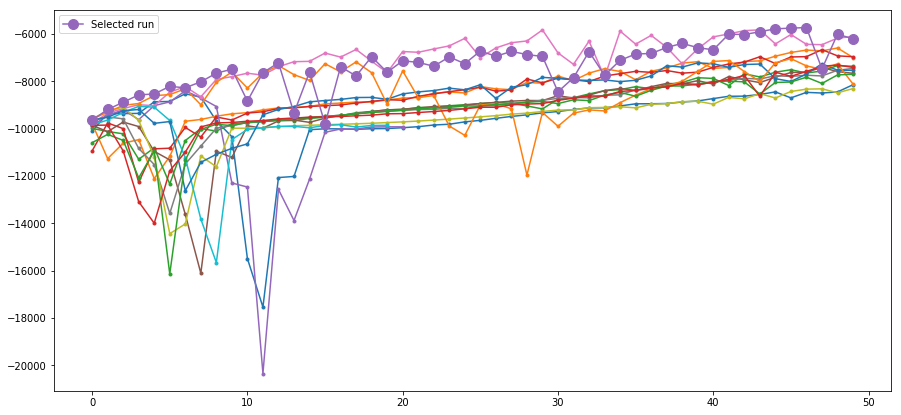

In [72]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [35]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (135, 135)


shape of annotator representation (T, R_t)= (135, 4)


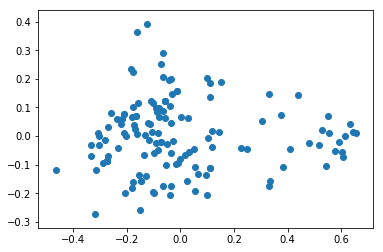

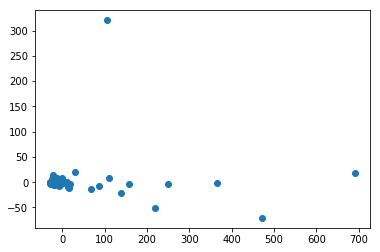

array([[235., 434., 481., 209.],
       [  0.,  16.,  45., 347.],
       [ 12.,  12.,   8.,   6.],
       [ 40.,  72.,  50.,  17.],
       [269., 344., 258.,  88.],
       [  0.,   2.,   3.,   1.],
       [ 34., 237., 328.,  86.],
       [  2.,   5.,   2.,   0.],
       [  0.,   2.,   3.,   3.],
       [ 52.,  81.,  88.,  47.],
       [ 33.,  22.,  34.,  38.],
       [ 96., 188., 165.,  76.],
       [127., 173., 136.,  27.],
       [  2.,   0.,   3.,   2.],
       [  2.,   1.,  11.,   1.],
       [ 14.,  28.,  33.,   1.],
       [  0.,   1.,   0.,   1.],
       [ 10.,  29.,  24.,  14.],
       [  2.,   6.,   9.,   1.],
       [  3.,   6.,   2.,   0.],
       [  0.,   2.,   2.,   0.],
       [  9.,   6.,   8.,   3.],
       [  0.,   1.,   2.,   0.],
       [  0.,   2.,   1.,   1.],
       [  3.,   1.,   0.,   1.],
       [  0.,   2.,   4.,   1.],
       [  0.,   0.,   4.,   0.],
       [  2.,   4.,  12.,   1.],
       [  1.,   1.,   2.,   1.],
       [ 85., 112., 111.,  51.],
       [  

In [36]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [37]:
#different M_seted??
M_seted = 3

In [38]:
gMixture_Ind2 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("default cnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i_r = gMixture_Ind2.multiples_run(15,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000827 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1498, 4)
Betas:  (3, 4, 4)
Q estimate:  (7430, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 3.97 sec)	logL: -9301.779	
Iter 2/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9739.508	Tol1: 0.04706	Tol2: 0.15335	
Iter 3/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9789.401	Tol1: 0.00512	Tol2: 0.20906	
Iter 4/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -11484.365	Tol1: 0.17314	Tol2: 0.33124	
Iter 5/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -11378.355	Tol1: 0.00923	Tol2: 0.82975	
Iter 6/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -10166.178	Tol1: 0.10653	Tol2: 0.63534	
Iter 7/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9722.746	Tol1: 0.04362	Tol2: 0.57422	
Iter 8/50
M step: done,  E step: done //  (in 1.40

M step: done,  E step: done //  (in 1.37 sec)	logL: -10073.180	Tol1: 0.07739	Tol2: 0.39099	
Iter 7/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -11731.098	Tol1: 0.16459	Tol2: 0.57280	
Iter 8/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -12709.067	Tol1: 0.08337	Tol2: 0.59751	
Iter 9/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -15358.500	Tol1: 0.20847	Tol2: 7.01434	
Iter 10/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -11182.934	Tol1: 0.27187	Tol2: 1.25168	
Iter 11/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9746.760	Tol1: 0.12843	Tol2: 0.57409	
Iter 12/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -10414.636	Tol1: 0.06852	Tol2: 0.12350	
Iter 13/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9650.271	Tol1: 0.07339	Tol2: 0.34902	
Iter 14/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9489.837	Tol1: 0.01662	Tol2: 0.17371	
Iter 15/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9485.277	Tol1: 0.00048	Tol

M step: done,  E step: done //  (in 1.36 sec)	logL: -9302.874	Tol1: 0.00708	Tol2: 0.10566	
Iter 18/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9217.538	Tol1: 0.00917	Tol2: 0.10555	
Iter 19/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9267.620	Tol1: 0.00543	Tol2: 0.05856	
Iter 20/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9134.070	Tol1: 0.01441	Tol2: 0.11993	
Iter 21/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9101.683	Tol1: 0.00355	Tol2: 0.06171	
Iter 22/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9030.744	Tol1: 0.00779	Tol2: 0.09862	
Iter 23/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -8983.262	Tol1: 0.00526	Tol2: 0.06173	
Iter 24/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -8892.301	Tol1: 0.01013	Tol2: 0.05733	
Iter 25/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9099.954	Tol1: 0.02335	Tol2: 0.05290	
Iter 26/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9180.367	Tol1: 0.00884	Tol2: 

In [39]:
Z_train_p = gMixture_Ind2.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind2.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind2.get_predictions_g(T_idx_unique) 

In [43]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default cnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(15,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=15,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000283 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1498, 4)
Betas:  (3, 4, 4)
Q estimate:  (7430, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 5.02 sec)	logL: -9590.202	
Iter 2/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -9293.979	Tol1: 0.03089	Tol2: 0.66405	
Iter 3/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9645.312	Tol1: 0.03780	Tol2: 0.17740	
Iter 4/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -9970.675	Tol1: 0.03373	Tol2: 0.32130	
Iter 5/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -14599.134	Tol1: 0.46421	Tol2: 0.46982	
Iter 6/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -11861.106	Tol1: 0.18755	Tol2: 1.00246	
Iter 7/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -9938.043	Tol1: 0.16213	Tol2: 1.11225	
Iter 8

M step: done,  E step: done //  (in 1.41 sec)	logL: -8787.599	Tol1: 0.00745	Tol2: 0.06902	
Iter 27/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8776.901	Tol1: 0.00122	Tol2: 0.08553	
Iter 28/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8648.634	Tol1: 0.01461	Tol2: 0.06256	
Iter 29/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -9134.584	Tol1: 0.05619	Tol2: 0.07696	
Iter 30/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8699.896	Tol1: 0.04759	Tol2: 0.19288	
Iter 31/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8601.002	Tol1: 0.01137	Tol2: 0.09165	
Iter 32/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8441.579	Tol1: 0.01854	Tol2: 0.09608	
Iter 33/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8554.077	Tol1: 0.01333	Tol2: 0.08194	
Iter 34/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8333.529	Tol1: 0.02578	Tol2: 0.15762	
Iter 35/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8353.802	Tol1: 0.00243	Tol2: 

M step: done,  E step: done //  (in 1.44 sec)	logL: -9447.993	Tol1: 0.00153	Tol2: 0.07051	
Iter 16/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -9418.263	Tol1: 0.00315	Tol2: 0.09923	
Iter 17/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9373.518	Tol1: 0.00475	Tol2: 0.08710	
Iter 18/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9362.491	Tol1: 0.00118	Tol2: 0.07290	
Iter 19/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9331.420	Tol1: 0.00332	Tol2: 0.08101	
Iter 20/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -9326.013	Tol1: 0.00058	Tol2: 0.05070	
Iter 21/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -9299.362	Tol1: 0.00286	Tol2: 0.08544	
Iter 22/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -9280.155	Tol1: 0.00207	Tol2: 0.06742	
Iter 23/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -9271.320	Tol1: 0.00095	Tol2: 0.03995	
Iter 24/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -9246.043	Tol1: 0.00273	Tol2: 

M step: done,  E step: done //  (in 4.84 sec)	logL: -9599.795	
Iter 2/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9764.218	Tol1: 0.01713	Tol2: 0.17404	
Iter 3/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -10414.330	Tol1: 0.06658	Tol2: 0.35307	
Iter 4/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -13966.922	Tol1: 0.34113	Tol2: 0.45325	
Iter 5/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -11199.189	Tol1: 0.19816	Tol2: 1.35043	
Iter 6/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -10268.174	Tol1: 0.08313	Tol2: 0.71831	
Iter 7/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9872.206	Tol1: 0.03856	Tol2: 0.53083	
Iter 8/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -9816.495	Tol1: 0.00564	Tol2: 0.06533	
Iter 9/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9747.302	Tol1: 0.00705	Tol2: 0.07569	
Iter 10/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9718.276	Tol1: 0.00298	Tol2: 0.07467	
Iter 11/50
M step: done

In [44]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

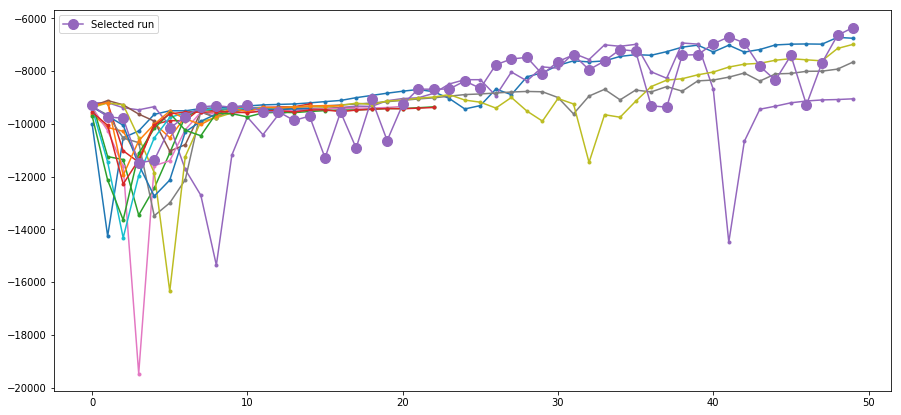

In [41]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics

In [14]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.9933,0.9933,0.9908


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.4752,0.4752,0.4489


In [ ]:
#upper bound global confusion matrix..
prob_Yz = generate_confusionM(Z_train_pred, label_I.y_obs_repeat)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


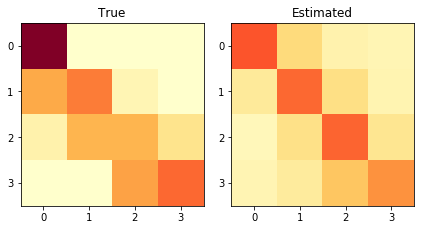

JS divergence: 0.1239	Norm Frobenius: 0.1647


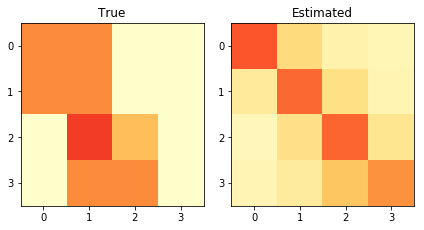

JS divergence: 0.2360	Norm Frobenius: 0.2496


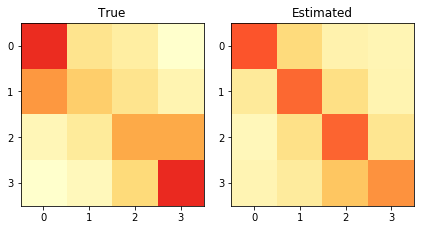

JS divergence: 0.0661	Norm Frobenius: 0.1512


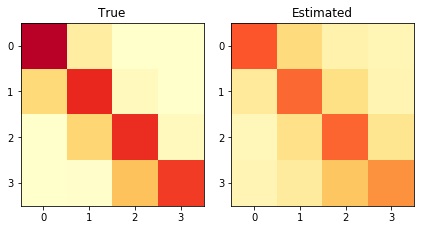

JS divergence: 0.0910	Norm Frobenius: 0.1263


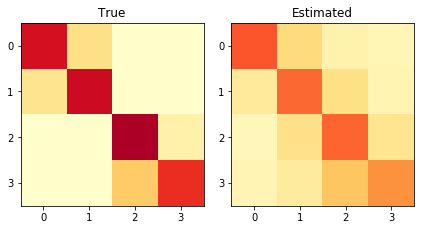

JS divergence: 0.1316	Norm Frobenius: 0.1558


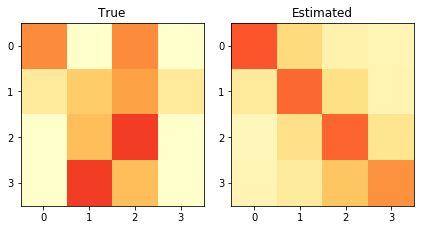

JS divergence: 0.2203	Norm Frobenius: 0.2441


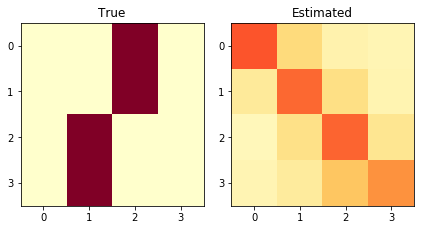

JS divergence: 0.6732	Norm Frobenius: 0.5207


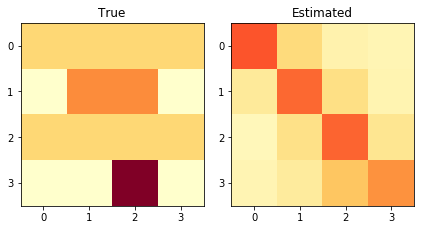

JS divergence: 0.2187	Norm Frobenius: 0.2738


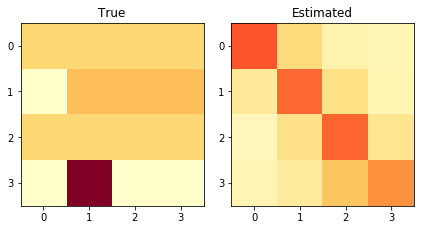

JS divergence: 0.2749	Norm Frobenius: 0.3148


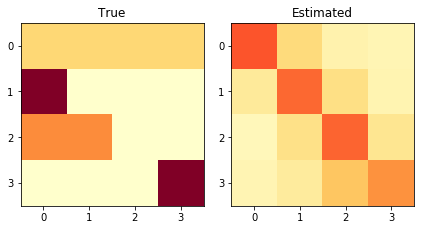

JS divergence: 0.4291	Norm Frobenius: 0.3830


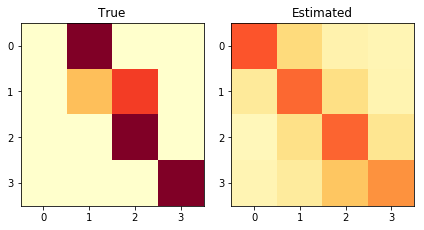

JS divergence: 0.3426	Norm Frobenius: 0.3449


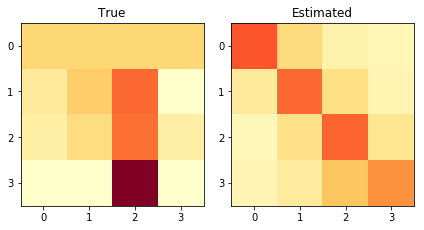

JS divergence: 0.1903	Norm Frobenius: 0.2685


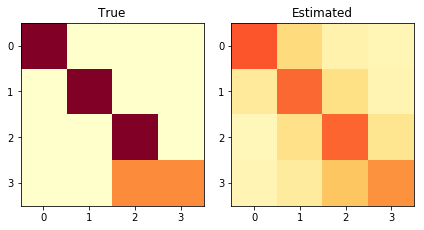

JS divergence: 0.2140	Norm Frobenius: 0.2203


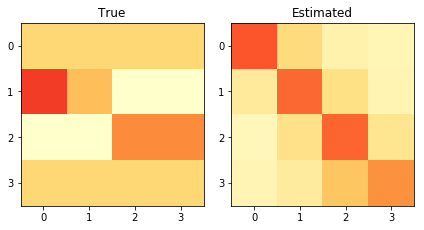

JS divergence: 0.1726	Norm Frobenius: 0.2277


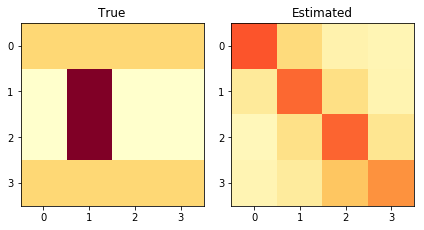

JS divergence: 0.2681	Norm Frobenius: 0.3117
Calculate confusion matrix on global version


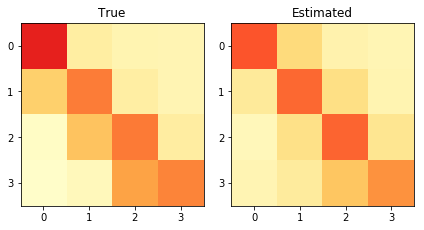

JS divergence: 0.0264	Norm Frobenius: 0.0803
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.4613,0.4613,0.3942,0.2883,0.2687,0.1975,0.1582,0.0803,0.0264


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.3877,0.3877,0.3073


In [17]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


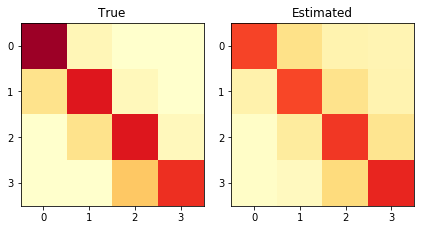

JS divergence: 0.0685	Norm Frobenius: 0.1105


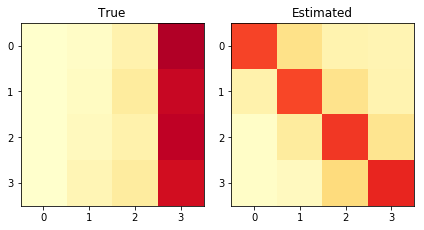

JS divergence: 0.4137	Norm Frobenius: 0.4289


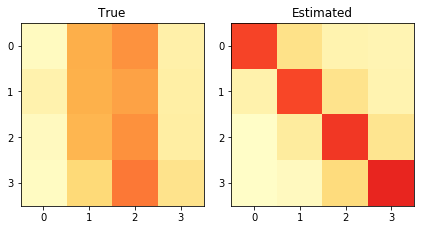

JS divergence: 0.1857	Norm Frobenius: 0.2778


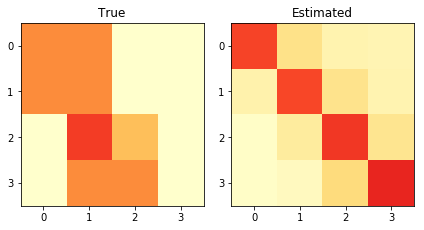

JS divergence: 0.3108	Norm Frobenius: 0.3165


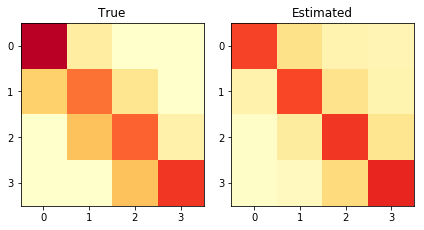

JS divergence: 0.0631	Norm Frobenius: 0.1068


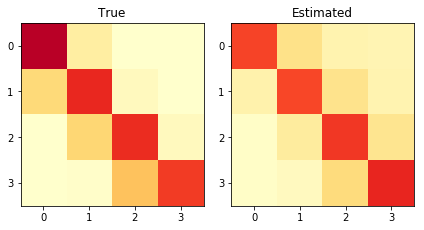

JS divergence: 0.0674	Norm Frobenius: 0.1030


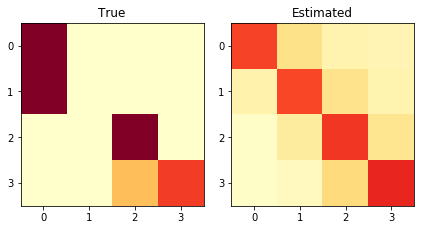

JS divergence: 0.2969	Norm Frobenius: 0.3179


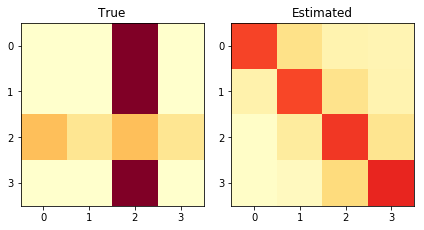

JS divergence: 0.5425	Norm Frobenius: 0.4836


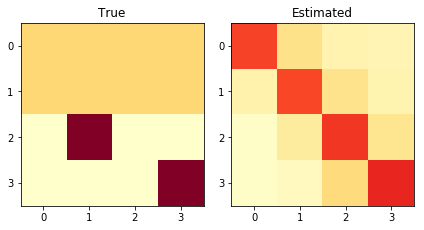

JS divergence: 0.2819	Norm Frobenius: 0.3365


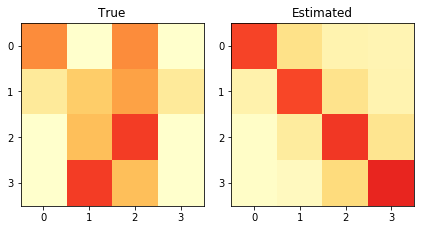

JS divergence: 0.2775	Norm Frobenius: 0.2997


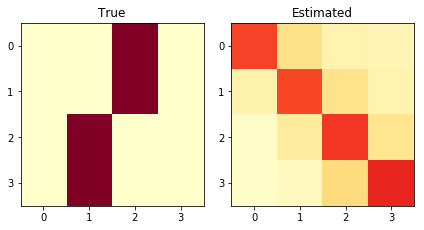

JS divergence: 0.7537	Norm Frobenius: 0.5674


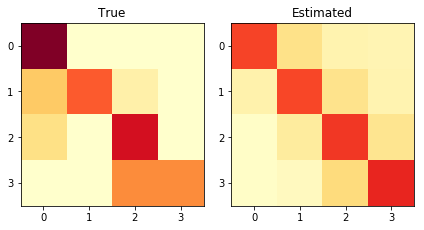

JS divergence: 0.1490	Norm Frobenius: 0.1681


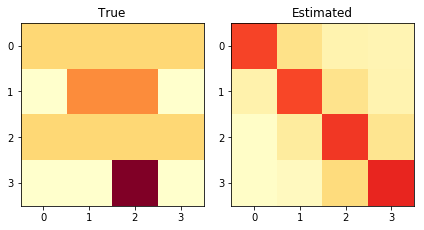

JS divergence: 0.2608	Norm Frobenius: 0.3292


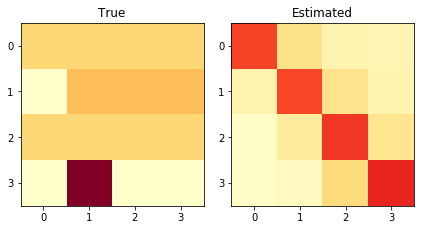

JS divergence: 0.3427	Norm Frobenius: 0.3690


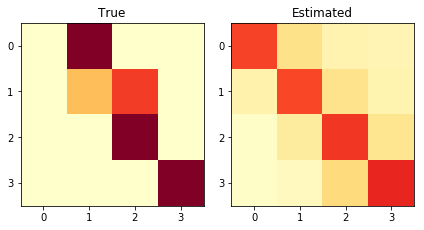

JS divergence: 0.2962	Norm Frobenius: 0.3273
Calculate confusion matrix on global version


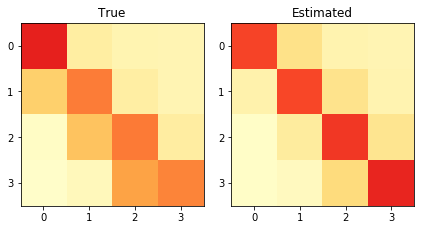

JS divergence: 0.0317	Norm Frobenius: 0.1123
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6308,0.6308,0.6385,0.3126,0.2914,0.207,0.1572,0.1123,0.0317


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.2275,0.2275,0.1971


In [19]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


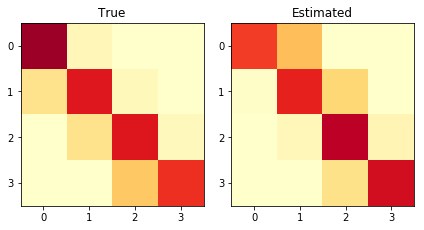

JS divergence: 0.0622	Norm Frobenius: 0.1298


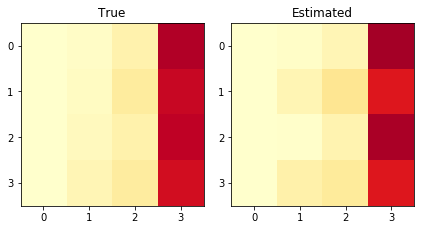

JS divergence: 0.0063	Norm Frobenius: 0.0314


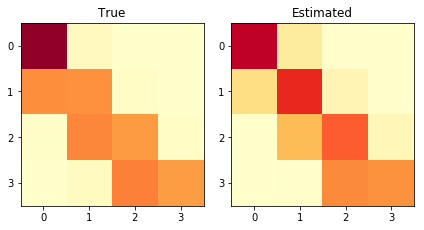

JS divergence: 0.0331	Norm Frobenius: 0.1150


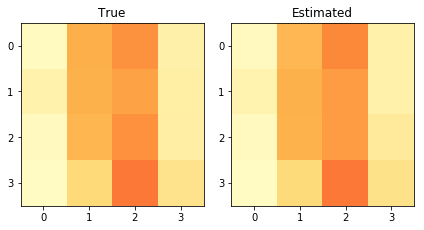

JS divergence: 0.0008	Norm Frobenius: 0.0166


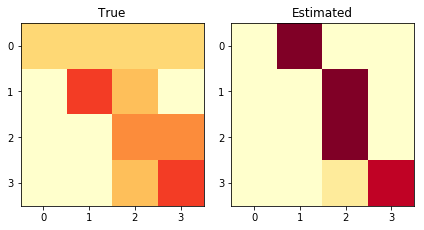

JS divergence: 0.3396	Norm Frobenius: 0.3721


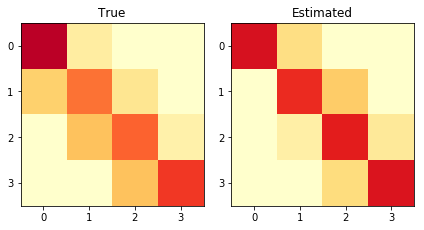

JS divergence: 0.0574	Norm Frobenius: 0.1189


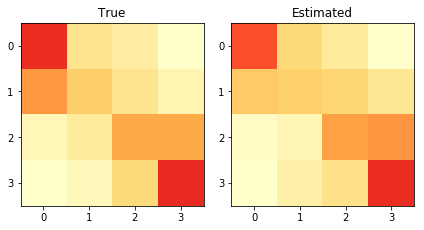

JS divergence: 0.0155	Norm Frobenius: 0.0663


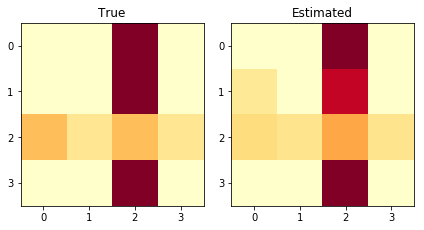

JS divergence: 0.0228	Norm Frobenius: 0.0634


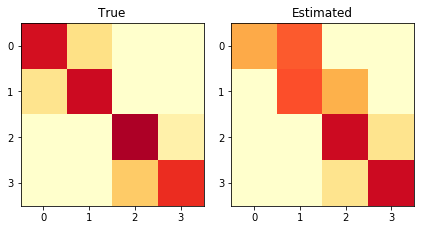

JS divergence: 0.1076	Norm Frobenius: 0.1893


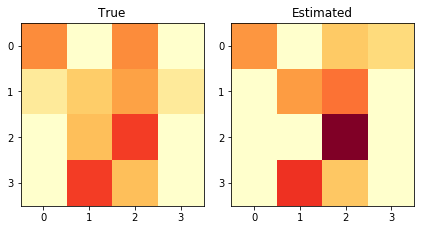

JS divergence: 0.1201	Norm Frobenius: 0.1581


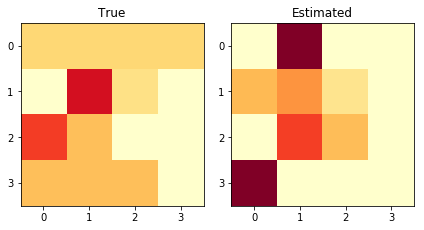

JS divergence: 0.4389	Norm Frobenius: 0.3802


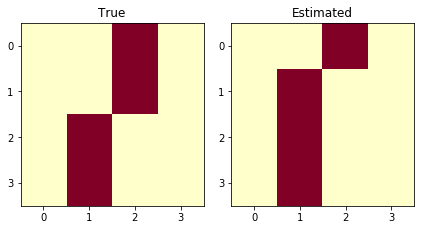

JS divergence: 0.2500	Norm Frobenius: 0.3536


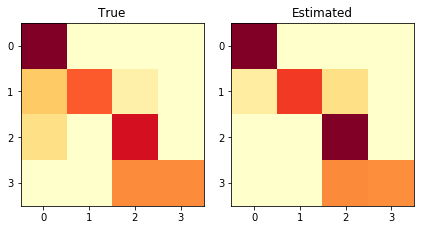

JS divergence: 0.0374	Norm Frobenius: 0.0889


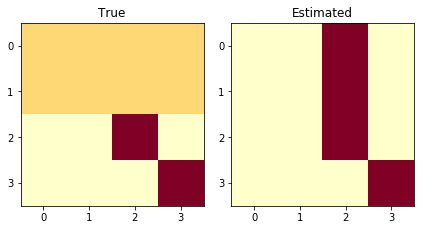

JS divergence: 0.2744	Norm Frobenius: 0.3062


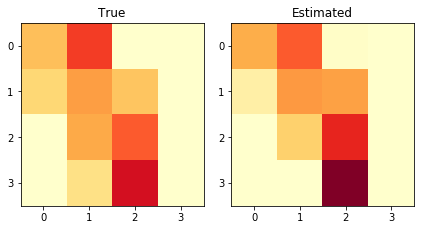

JS divergence: 0.0393	Norm Frobenius: 0.0980
Calculate confusion matrix on global version


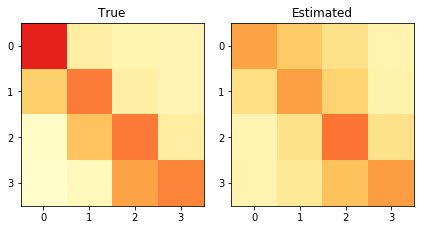

JS divergence: 0.0465	Norm Frobenius: 0.1208
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.5908,0.5908,0.5576,0.2496,0.2128,0.1222,0.0587,0.1208,0.0465


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.3307,0.3307,0.2296


In [21]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


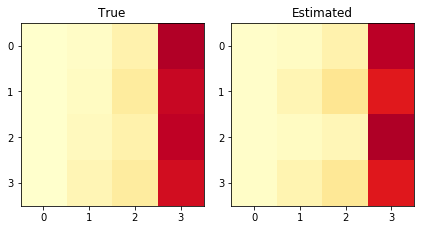

JS divergence: 0.0082	Norm Frobenius: 0.0313


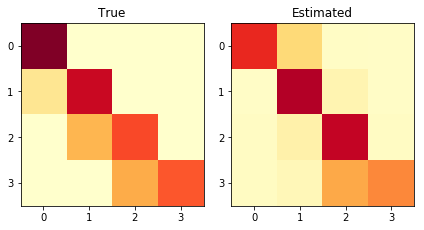

JS divergence: 0.0995	Norm Frobenius: 0.1376


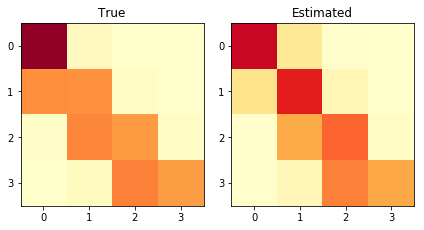

JS divergence: 0.0352	Norm Frobenius: 0.1199


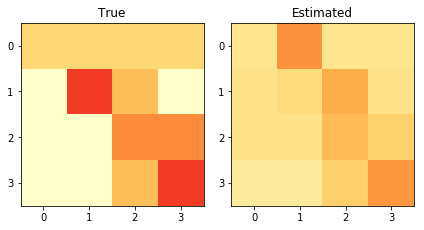

JS divergence: 0.1709	Norm Frobenius: 0.1875


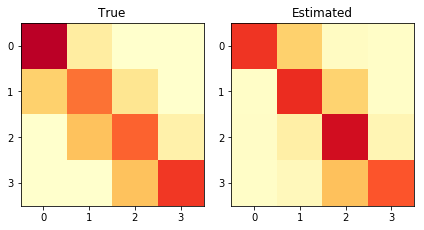

JS divergence: 0.0683	Norm Frobenius: 0.1293


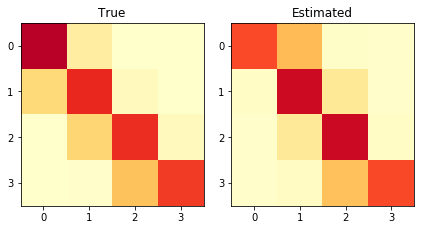

JS divergence: 0.0515	Norm Frobenius: 0.1152


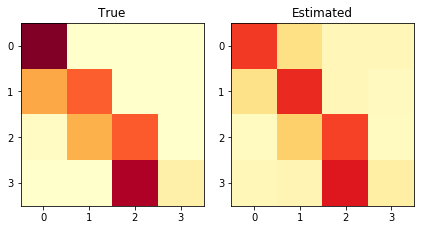

JS divergence: 0.0897	Norm Frobenius: 0.1282


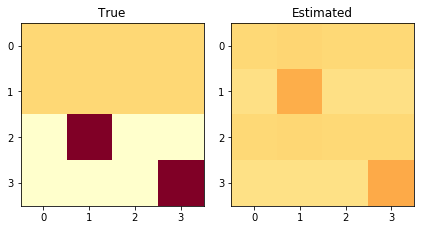

JS divergence: 0.2384	Norm Frobenius: 0.2788


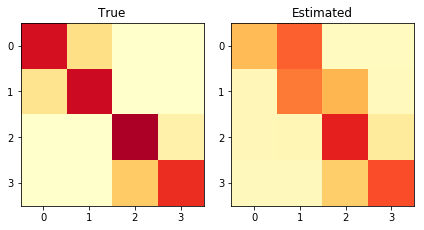

JS divergence: 0.1341	Norm Frobenius: 0.1995


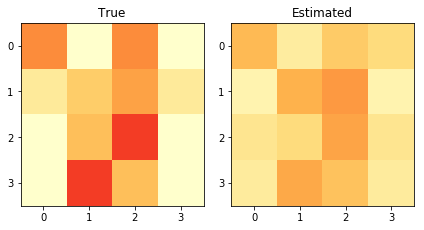

JS divergence: 0.1459	Norm Frobenius: 0.1552


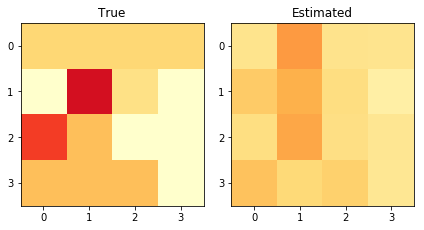

JS divergence: 0.1649	Norm Frobenius: 0.2024


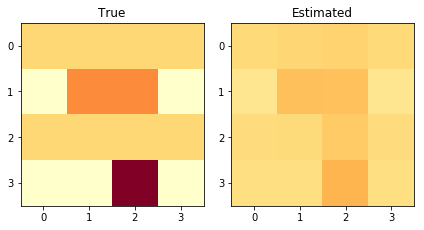

JS divergence: 0.1574	Norm Frobenius: 0.2032


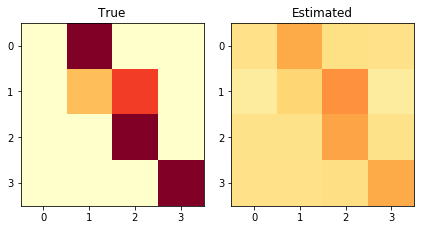

JS divergence: 0.3293	Norm Frobenius: 0.3049


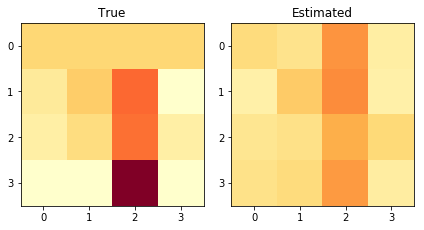

JS divergence: 0.1213	Norm Frobenius: 0.1841


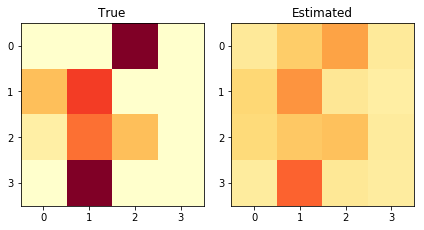

JS divergence: 0.2211	Norm Frobenius: 0.2326
Calculate confusion matrix on global version


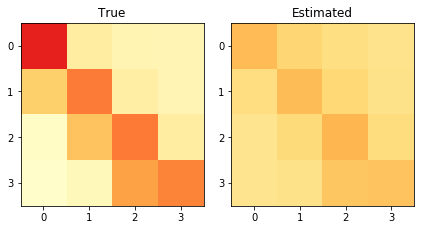

JS divergence: 0.0927	Norm Frobenius: 0.1673
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.3238,0.3238,0.2569,0.2178,0.1912,0.1229,0.0675,0.1673,0.0927,0.1302,0.1217


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.6692,1.1338,0.5818,1.0363


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.2868,0.2868,0.2238


In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [26]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'gMixture_Global' is not defined

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [46]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()